# Part 1: Cloud Environment Setup

Since this initial homework uses the whole "big data" stack, including Apache Spark, we will first need to do some software setup.

Generally speaking we will be running command-line options (eg to install software on the host machine) using the `!` operation, and we will be using `pip` to install Python libraries.



## 1.1 Installing Spark on Google Colab

For big data analysis on a cluster, we'll need to learn to use Apache Spark.  You don't need to fully follow the details here to install Spark on Colab, but you do need to execute the cell!

Select it and hit [Shift]-[Enter] to run, or click on the "play" triangle to the left.

In [1]:
## Let's install Apache Spark on Colab

!wget https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install findspark

import os

os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

--2022-05-10 04:52:04--  https://downloads.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300971569 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop3.2.tgz’

spark-3.2.1-bin-had 100%[===================>] 287.03M  83.0MB/s    in 3.6s    

2022-05-10 04:52:08 (79.0 MB/s) - ‘spark-3.2.1-bin-hadoop3.2.tgz’ saved [300971569/300971569]



Good, the software should be installed.

Now you need to run three more Cells that configure Jupyter for Apache Spark, set up the environment, and connect to Spark.

In [2]:
import findspark

findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SQLContext

In [3]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


## 2.1 A Simple Program to Read from the Web and Invoke Spark

The cell below uses the **Pandas** library to read a table from the given web page (the Wikipedia information on films in the year 2010).  The code loads this into a list of **DataFrame**s called `films_2010`.  We then pull the table at index 3, then do some simple **data wrangling** on `top_films` to set up the appropriate types.

Select the Cell below and then select the Run button which appeared over the brackets.

In [4]:
!pip install money-parser

In [7]:
import pandas as pd
from money_parser import price_dec

def extract_number(x):
  return round(price_dec(x) / 1000000, 2)

films_2010 = pd.read_html('https://en.wikipedia.org/wiki/2010_in_film')

top_films = films_2010[3]

top_films.set_index('Rank', inplace=True)

top_films['Revenue (millions)'] = top_films['Worldwide gross'].apply(extract_number)

top_films

,Title,Distributor,Worldwide gross,Revenue (millions)
Rank,,,,
1,Toy Story 3,Disney,"$1,066,969,703",1066.97
2,Alice in Wonderland,Disney,"$1,025,467,110",1025.47
3,Harry Potter and the Deathly Hallows - Part 1,Warner Bros.,"$976,536,918",976.54
4,Inception,Warner Bros.,"$826,137,188",826.14
5,Shrek Forever After,Paramount,"$752,600,867",752.60
6,The Twilight Saga: Eclipse,Summit,"$698,491,347",698.49
7,Iron Man 2,Paramount,"$623,933,331",623.93
8,Tangled,Disney,"$592,461,732",592.46
9,Despicable Me,Universal,"$543,113,985",543.11


Can we programmatically compute how many entries were scored as top films?

In [10]:
# You can use the Python len() function on a dataframe to figure out how many rows!

# TODO: Update dataframe_length with your code here!
dataframe_length = len(top_films)
print(dataframe_length)

10


Now we will copy the table over to **Apache Spark**, which is a big data engine capable of processing giant tables.

We will **query** the table to get top films from Disney.

In [11]:
from pyspark.sql.types import *

# The 'schema' specifies the column names and data types
schema = StructType([StructField('Title', StringType(), nullable=True), \
            StructField('Distributor', StringType(), nullable=False), \
            StructField('Gross', StringType(), nullable=False), \
            StructField('Revenue_M', DecimalType(), nullable=False)])

# This loads a Pandas DataFrame into Apache Spark
top_films_spark = spark.createDataFrame(top_films, \
                                         schema=schema)

# Now use Spark to filter only those rows where the distributor is 'Disney'
disney_films = top_films_spark.filter(top_films_spark.Distributor == 'Disney')
display(disney_films.collect())

[Row(Title='Toy Story 3', Distributor='Disney', Gross='$1,066,969,703', Revenue_M=Decimal('1067')),
 Row(Title='Alice in Wonderland', Distributor='Disney', Gross='$1,025,467,110', Revenue_M=Decimal('1025')),
 Row(Title='Tangled', Distributor='Disney', Gross='$592,461,732', Revenue_M=Decimal('592'))]

Congratulations, you have just run a very simple Spark program!

## 2.2 Something a Little More Fun
Running the cell below will create a scatter plot. 

**Your task is to edit this cell such that:***

1. The text (which says “CIS 545 student”) should be replaced with your full name.
2. The number of values sampled should be 500, and you should  change the figure title to match.

4. The x-axis should be labeled “Index”.

You may run this cell repeatedly to see the output.

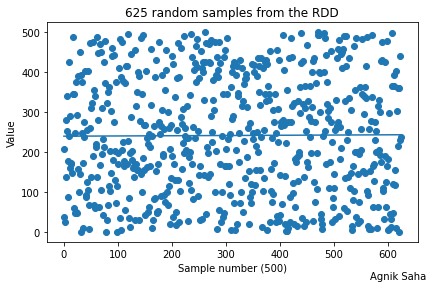

In [13]:
# We’ll be using Matplotlib to plot a visualization
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# Create a Spark dataset with values 0 thru 499
rdd = spark.sparkContext.parallelize(range(500))

# TODO: change this line so we sample 500 values
# Sample 625 values from the RDD
y = np.array(rdd.takeSample(True, 625, 1))
# Create an array with the indices
x = np.array(range(len(y)))

# Create a plot with a caption, X and Y legends, etc
x_label = 'Sample number (500)'
y_label = 'Value'
student = 'Agnik Saha'

plt.title(str(len(y)) + ' random samples from the RDD')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.figtext(0.995, 0.01, student, ha='right', va='bottom')
# Scatter plot that fits within the box
plt.scatter(x, y)
plt.tight_layout()

# Now fit a trend line to the data and plot it over the scatter plot
m, c = np.polyfit(x, y, 1)
plt.plot(x, m*x + c)

# Save the SVG
plt.savefig('hw0.svg')